# League of Legends Game Prediction Model
Summary: This model intends to predict the winner of a League of Legends game based on statistics at the 15 minute mark.

Author: Mark Du

Assignment: Semester Project for CSI 4352 - Intro to Data Mining

Due Date: 12-01-2020



Scraper to fill values for dataset
(Recommended to run on your own machine with personal API key, will timeout on colab)

In [ ]:
#@title Scraper code { display-mode: "form" }
# Scraper to fill missing values from this dataset
#  (Running this takes ~20 hours to get the values, perform on own machine)

from riotwatcher import LolWatcher, ApiError
from datetime import datetime
import time

api_key = open('api_key.txt', 'r').read()

lol_watcher = LolWatcher(api_key)
region = 'na1'
TIME_CUTOFF = 15

# File to write the data to
data_file = open('objectives.csv', 'w')

# Game ID file
id_file = 'game_ids.txt'
data = list(list()) # Contains list of [blue_Drag, blue_rift, red_drag, red_rift]

# Grabs dragon and rift count for the game 
def get_objective_data(match_id):
    # Get all dragon kills before 15 mins (1-5 is blue team, 6-10 red team)
    # Team that gets first rift herald (both can be 0, only 1 can be 1)
    blue_rifts = 0
    red_rifts = 0
    blue_drags = 0
    red_drags = 0
    mt = lol_watcher.match.timeline_by_match(region=region, match_id=match_id)
    for frame in mt['frames']:
        time = frame['timestamp']  # Time is in miliseconds
        minute = time // (1000 * 60)  # 1000ms = 1 second, 60 seconds/min (Get 15th min mark)

        events = frame['events']
        pf = frame['participantFrames']

        # All events in first 15 minutes
        if minute > 0 and minute < TIME_CUTOFF:
            for e in events:
                if e['type'] == 'ELITE_MONSTER_KILL':
                    killer_id = e['killerId']

                    # Get which team killed dragon
                    if e['monsterType'] == 'DRAGON':
                        # Which team got dragon
                        if killer_id <= 5:
                            blue_drags += 1
                        elif killer_id >= 6:
                            red_drags += 1

                    if e['monsterType'] == 'RIFTHERALD':
                        # Which team got rift
                        if killer_id <= 5:
                            blue_rifts += 1
                        elif killer_id >= 6:
                            red_rifts += 1

    data.append([blue_drags, blue_rifts, red_drags, red_rifts])


def write_data_out():
    for item in data:
        data_string = ','.join(str(num) for num in item)  # Convert list of numbers into a csv string
        print(data_string, file=data_file)


# Call function
with open(id_file, 'r') as file:
    count = 0
    for match_id in file:
        if count == 30:
            break
        try:
            get_objective_data(int(match_id))  # Cast as integer
            time.sleep(1.5)
        except Exception:
            print('Bad call, continuing')
        count += 1

# Write stats to output file
write_data_out()




# Load in dataset



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load in dataset
df = pd.read_csv('/content/drive/My Drive/data_final.csv', sep=',')
pd.set_option('display.max_columns', None)
# print(df.head(5))

# Data notes: Contains the differences in stats for both teams
#  A positive value indicates that blue team has an advantage
#  A negative value indicates that red team has an advantage
x = df.iloc[:, 1:len(df.columns)]  # Get x values of the data (8 columns)
y = df[['blue_win']] # Get target value (blue win)\\

# Split into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, train_size=0.8, random_state=1)
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Standardize the data in the x_train and x_test set
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# print train and test shapes 
print("xtrain:",x_train.shape)
print("xtest:", x_test.shape)
print("ytrain:", y_train.shape)
print("ytest:", y_test.shape)


xtrain: (38920, 8)
xtest: (9731, 8)
ytrain: (38920, 1)
ytest: (9731, 1)


# Show important statistics of the loaded dataset


In [ ]:
# Display total # of wins/losses, some outlier values, and average gold difference

# Target value is roughly 50% wins/losses
blue_wins = len(y.loc[y['blue_win'] == 1])
bw_perc = blue_wins/(len(y)) * 100
print(f'Percentage of blue wins: {round(bw_perc, 3)}%')

# Percentage of games with large gold differences (greater than 10000)
#  (Approx 4% of games in the dataset)
large_diffs = len(x.loc[abs(x['GoldDiff']) > 10000])
gold_diff_perc = large_diffs/(len(x)) * 100
print(f'Number of large gold differences: {round(gold_diff_perc, 3)}%')

# Average gold difference is approx 146
avg_gold_diff = x['GoldDiff'].mean()
print(f'Average gold difference: {int(avg_gold_diff)}')


Percentage of blue wins: 50.542%
Number of large gold differences: 3.983%
Average gold difference: 146


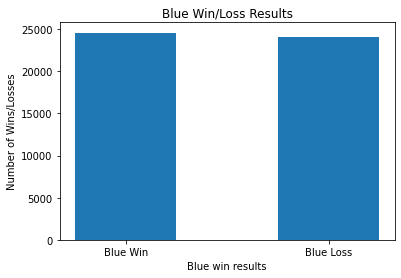

In [ ]:
import matplotlib.pyplot as plt
# Display a visual bar graph for wins/losses
len1 = len(y[y['blue_win'] == 1])
len2 = len(y[y['blue_win'] == 0])

# x and y labels
x_plt = ['Blue Win', 'Blue Loss']
y_plt = [len1, len2]

# Axis labels
plt.xlabel('Blue win results')
plt.ylabel('Number of Wins/Losses')
plt.title('Blue Win/Loss Results')

# # Add with to X index to set location on X axis, set width of bar
plt.bar(x_plt, y_plt, width=0.5)

plt.savefig('win_loss.png')  # Save as png file
plt.show()

# Simplistic classification approach using gold difference

In [ ]:
# Displays the accuracy of classfying the dataset 
#  using a simplistic gold difference approach

def gold_accuracy(x, y):
  blue_wins = 0
  blue_losses = 0

  for index in range(0, len(x)):
    if x.iloc[index][0] > 0 and y.iloc[index][0] == 1:
      blue_wins += 1
    elif x.iloc[index][0] < 0 and y.iloc[index][0] == 0:
      blue_losses += 1

  acc = (blue_wins+blue_losses)/(len(x)) * 100
  print(f'Simplistic gold accuracy: {round(acc, 3)}%')

# Display results on full dataset
gold_accuracy(x, y)


Simplistic gold accuracy: 77.76%


# Building a model

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import BatchNormalization

input_dim = 8 # Our dataset contains 8 features

# Sequential model with dropout and batch normalization
def create_seq_model():
  model = Sequential()            
  model.add(Dense(16, activation='relu', input_shape=(input_dim,)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # opt = SGD(learning_rate=0.001) # SGD optimizer did slightly worse than Adam
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model

m1 = create_seq_model()
print(m1.summary())

# Model with more layers - didn't end up having a significant increase in accuracy
def model2():
  model = Sequential()            
  model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=0.0005)
  model.compile(optimizer=opt, loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

m2 = model2()
print(m2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,297
Trainable params: 1,265
Non-trainable params: 32
_____________________________________________________

# Train the data

Epoch 1/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4886 - accuracy: 0.7622 - val_loss: 0.4518 - val_accuracy: 0.7815
Epoch 2/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4661 - accuracy: 0.7754 - val_loss: 0.4485 - val_accuracy: 0.7851
Epoch 3/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4635 - accuracy: 0.7749 - val_loss: 0.4462 - val_accuracy: 0.7853
Epoch 4/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4585 - accuracy: 0.7785 - val_loss: 0.4495 - val_accuracy: 0.7819
Epoch 5/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4605 - accuracy: 0.7799 - val_loss: 0.4482 - val_accuracy: 0.7865
Epoch 6/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4598 - accuracy: 0.7804 - val_loss: 0.4465 - val_accuracy: 0.7833
Epoch 7/100
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4600 - accuracy: 0.7805 - val_loss: 0.4451 - val_ac

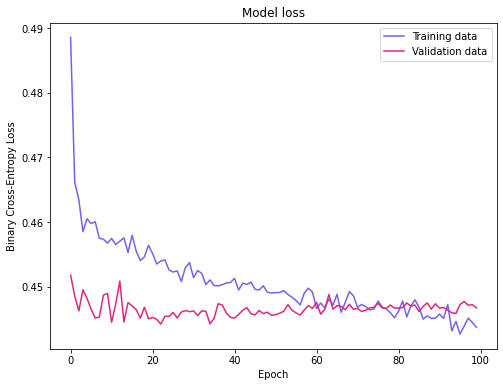

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# model = create_seq_model()
model = model2()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10,  
                              min_delta=1e-4, mode='min')
stop_alg = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the data (should see decreasing loss, and increasing accuracy)
hist = model.fit(x_train, y_train, batch_size=25, epochs=100, 
          callbacks=[stop_alg, reduce_lr], shuffle=True,
          validation_data=(x_test, y_test))

# Show loss on training and test set
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Visualize results
fig = plt.figure(figsize=(8,6))
plt.plot(loss, color='#785ef0')
plt.plot(val_loss, color='#dc267f')
plt.title('Model loss')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training data',
 'Validation data'], loc='upper right')
plt.show()

# Make predictions on test data

In [ ]:
# Generate predictions using the test data
y_predict = model.predict(x_test, batch_size=5) # Returns floating point values
y_predict = (y_predict > 0.5) # Convert floats to true/false values

# Use confusion matrix to show results of binary classification
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_predict)  

# TP = true positive, FP = false positive
# FN = false negative, TN = true negative
tp = matrix[0][0]
fp = matrix[0][1]
fn = matrix[1][0]
tn = matrix[1][1] 

# Get accuracy from confusion matrix
accuracy = (tp+tn)/(tp+tn+fp+fn) * 100
print(f'Accuracy: {round(accuracy, 3)}%')

# Show true positives, true negatives, false pos, and false neg
print("True positives:", tp)
print("True negatives:", tn)
print("False positives:", fp)
print("False negatives:", fn)

Accuracy: 78.491%
True positives: 3604
True negatives: 4034
False positives: 1189
False negatives: 904


# K-fold Cross Validation

Accuracy: 78.368%
Balanced acc score: 0.7836840086092698
Balanced error rate: 0.2163159913907302
Accuracy: 78.941%
Balanced acc score: 0.7893098757434804
Balanced error rate: 0.21069012425651956
Accuracy: 79.003%
Balanced acc score: 0.7900108060374377
Balanced error rate: 0.20998919396256233
Accuracy: 78.397%
Balanced acc score: 0.7839627542620229
Balanced error rate: 0.2160372457379771
Accuracy: 79.044%
Balanced acc score: 0.7907448756284157
Balanced error rate: 0.20925512437158433
Average accuracy across 5 folds: 78.751%


<Figure size 640x480 with 0 Axes>

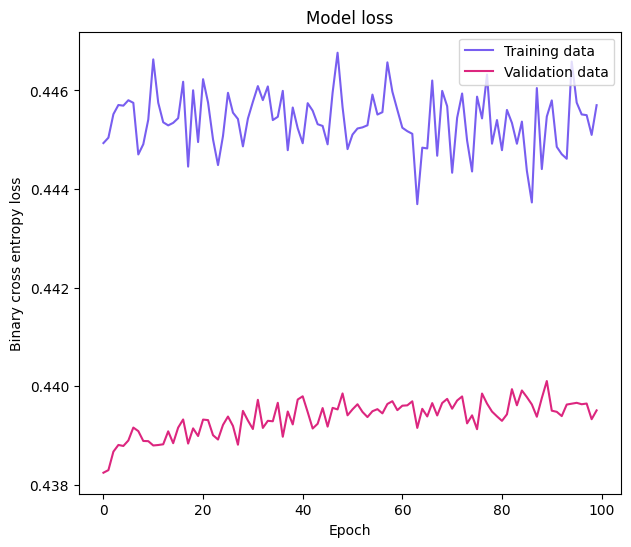

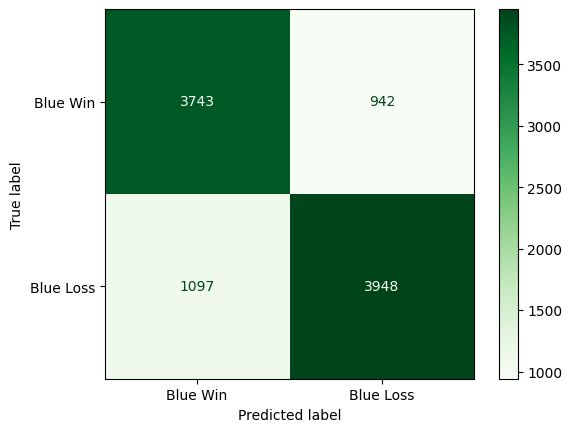

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from tensorflow.keras.estimator import model_to_estimator
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Store sum of averages
averages = []

# Standardizer
scaler = StandardScaler()

# Convert x and y data to numpy arrays (required for KFold cross validation)
xt = x.to_numpy()
yt = y.to_numpy()

k_fold = KFold(n_splits=5)
model = create_seq_model()

# Split into 10 different folds
for train_index, test_index in k_fold.split(xt):

  # Gather training/testing data sets
  X_train, X_test = xt[train_index], xt[test_index]
  Y_train, Y_test = yt[train_index], yt[test_index]

  # Standardize training data
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)

  # Callbacks
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10,  
                              min_delta=1e-4, mode='min')
  stop_alg = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)


  # Train model and predict
  hist1 = model.fit(X_train, Y_train, batch_size=25, epochs=100, 
               verbose=0, callbacks=[stop_alg, reduce_lr], shuffle=True, 
               validation_data=(X_test, Y_test))
  model.save_weights('model.hdf5')

  Y_pred = model.predict(X_test)
  Y_pred = (Y_pred > 0.5)  # Map to true/false values

  # Generate confusion matrix for results
  matrix = confusion_matrix(Y_test, Y_pred, labels=[0, 1])  

  # TP = true positive, FP = false positive
  # FN = false negative, TN = true negative
  tp = matrix[0][0]
  fp = matrix[0][1]
  fn = matrix[1][0]
  tn = matrix[1][1] 

  fpr = fp/(fp+tn) # False positive rate
  fnr = fn/(fn+tp) # False negative rate

  # Get accuracy from confusion matrix
  accuracy = (tp+tn)/(tp+tn+fp+fn) * 100
  print(f'Accuracy: {round(accuracy, 3)}%')
  averages.append(accuracy)

  # Calculate balanced accuracy score
  bacc = balanced_accuracy_score(Y_test, Y_pred)
  print(f'Balanced acc score: {bacc}')

  # Calculate balanced error rate
  BER = 1-bacc
  print(f'Balanced error rate: {BER}') 
  # BER = 0.5 * (fpr + fnr)
  # print(f'Balanced error rate: {BER}') 

# Print average accuracy across 5 folds
print(f'Average accuracy across 5 folds: {round(np.average(averages), 3)}%')

# Visualize results
plt.clf()
fig1 = plt.figure(figsize=(7,6))

# Show loss on training and test set
train_loss = hist1.history['loss']
test_loss = hist1.history['val_loss']
plt.plot(train_loss, color='#785ef0')
plt.plot(test_loss, color='#dc267f')
plt.title('Model loss')
plt.ylabel('Binary cross entropy loss')
plt.xlabel('Epoch')
plt.legend(['Training data',
 'Validation data'], loc='upper right')
plt.show()

# Plot confusion matrix (for last fold)
cm = ConfusionMatrixDisplay(matrix, display_labels=['Blue Win', 'Blue Loss'])
cm.plot(include_values=True, cmap='Greens', values_format='d')


In [ ]:
# Calculate tp, tn, fp, fn of last run
# TP = true positive, FP = false positive
# FN = false negative, TN = true negative
tp = matrix[0][0]
fp = matrix[0][1]
fn = matrix[1][0]
tn = matrix[1][1] 

# Show true positives, true negatives, false pos, and false neg
print("True positives:", tp)
print("True negatives:", tn)
print("False positives:", fp)
print("False negatives:", fn)

True positives: 3735
True negatives: 3950
False positives: 950
False negatives: 1095


# Optimizing hyperparameters using Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.wrappers.scikit_learn import KerasClassifier

# Use grid search to optimize hyperparameters
model = KerasClassifier(build_fn=create_seq_model, verbose=0)
params = {"batch_size":[20, 25], "epochs":[100]}

# Use Grid search to find optimal parameters
gs = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", cv=5)
gs = gs.fit(x_train, y_train)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
# Print results from grid search
print(f'Best params for model: {gs.best_params_}')
print(f'Best accuracy score for model: {gs.best_score_}')

Best params for model: {'batch_size': 25, 'epochs': 100}
Best accuracy score for model: 0.7872302158273382


# Find coefficients of features from logistic regression

[ 1.47180386  0.0398143   0.07211769  0.37263079  0.23709775  0.01834244
  0.3399552  -0.05101229]


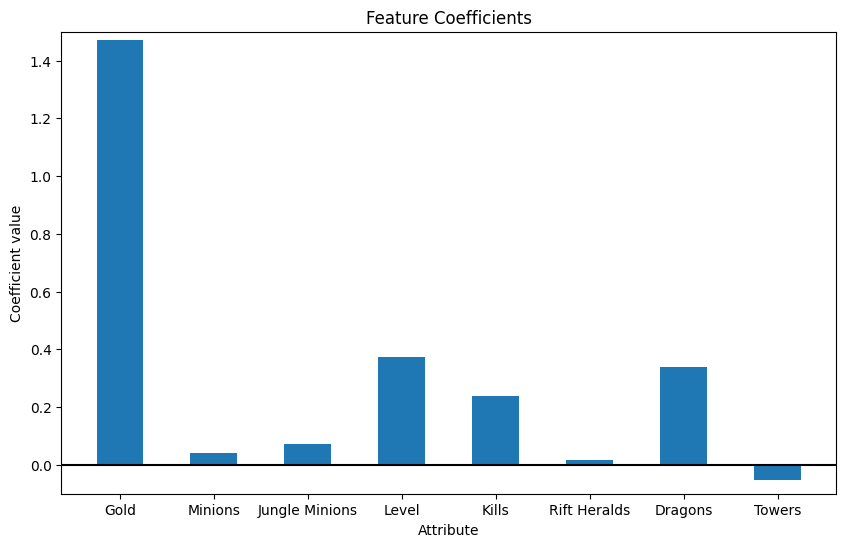

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Use logistic regression model and train
# x_train should be standardized already
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Get coefficient values for each feature
feature_vals = log_reg.coef_  # 2D array of coefficients for each feature

# Features and coefficient values
fts = ['Gold', 'Minions', 'Jungle Minions', 'Level', 'Kills', 
       'Rift Heralds', 'Dragons', 'Towers']
vals = feature_vals[0]
print(vals)

# Set plot attributes
plt.figure(figsize=(10,6))
plt.xlabel('Attribute')
plt.ylabel('Coefficient value')
plt.title('Feature Coefficients')
plt.ylim([-0.1, 1.5])
plt.axhline(y=0, color='black')

# Plot graph
plt.bar(fts, vals, width=0.5)
plt.savefig('FeatureCoeff.png')
plt.show()


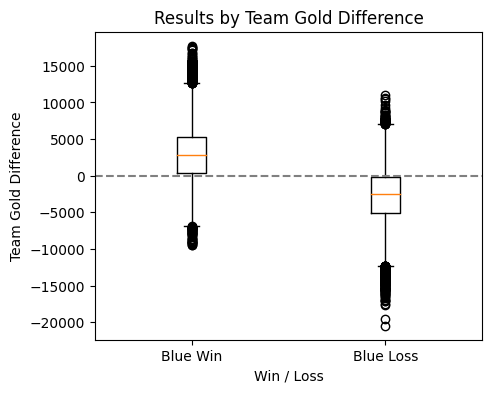

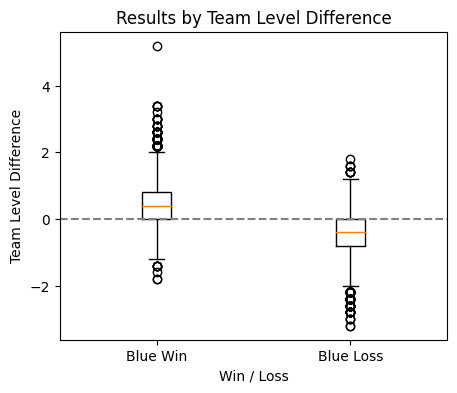

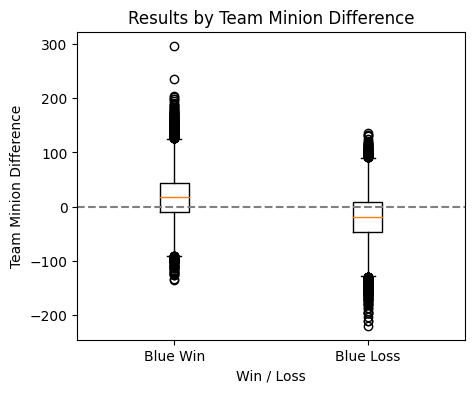

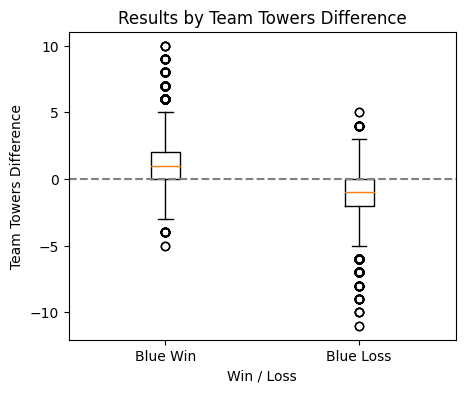

In [ ]:
# Display gold, minions, levels, towers w/ boxplot
import matplotlib.pyplot as plt

# Show gold difference graph
bw_gold = df[df['blue_win'] == 1]['GoldDiff']
bl_gold = df[df['blue_win'] == 0]['GoldDiff']
labels = [bw_gold, bl_gold]

plt.figure(figsize=(5,4))
plt.xlabel('Win / Loss')
plt.ylabel('Team Gold Difference')
plt.title('Results by Team Gold Difference')
plt.boxplot(labels, labels=['Blue Win', 'Blue Loss'])
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

# Sample outliers
# outliers = df[df['blue_win'] == 0][df['GoldDiff'] > 10000]
# print(outliers)

# Show level difference graph
bw_level = df[df['blue_win'] == 1]['LevelDiff']
bl_level = df[df['blue_win'] == 0]['LevelDiff']
labels = [bw_level, bl_level]

plt.figure(figsize=(5,4))
plt.xlabel('Win / Loss')
plt.ylabel('Team Level Difference')
plt.title('Results by Team Level Difference')
plt.boxplot(labels, labels=['Blue Win', 'Blue Loss'])
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

# Show minions graph
bw_minion = df[df['blue_win'] == 1]['MinionDiff']
bl_minion = df[df['blue_win'] == 0]['MinionDiff']
labels = [bw_minion, bl_minion]

plt.figure(figsize=(5,4))
plt.xlabel('Win / Loss')
plt.ylabel('Team Minion Difference')
plt.title('Results by Team Minion Difference')
plt.boxplot(labels, labels=['Blue Win', 'Blue Loss'])
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

# Show tower difference
bw_towers = df[df['blue_win'] == 1]['TowersDiff']
bl_towers = df[df['blue_win'] == 0]['TowersDiff']
labels = [bw_towers, bl_towers]

plt.figure(figsize=(5,4))
plt.xlabel('Win / Loss')
plt.ylabel('Team Towers Difference')
plt.title('Results by Team Towers Difference')
plt.boxplot(labels, labels=['Blue Win', 'Blue Loss'])
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()


# Testing alternative algorithms to see if we can improve accuracy results

In [ ]:
# Test classification results using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Try RandomForestClassifier algorithm
rf_params = {"n_estimators":[30, 50, 100]}
rf = RandomForestClassifier()

# Grid search to find optimal params
gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring="accuracy", cv=5)
gs_rf = gs_rf.fit(x_train, y_train)

print(f'Best params for random forest: {gs_rf.best_params_}')
print(f'Best accuracy score for random forest: {gs_rf.best_score_}')

Best params for random forest: {'n_estimators': 100}
Best accuracy score for random forest: 0.7778520041109969


In [ ]:
# Test classification results using support vector machine
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# SVC Classifier
svc = SVC()
svc_params = {"kernel":['linear', 'sigmoid', 'rbf']}
gs_svc = GridSearchCV(estimator=svc, param_grid=svc_params, scoring="accuracy", cv=5)
gs_svc = gs_svc.fit(x_train, y_train)
print(f'Best params for SVC: {gs_svc.best_params_}')
print(f'Best accuracy score for SVC: {gs_svc.best_score_}')

Best params for SVC: {'kernel': 'linear'}
Best accuracy score for SVC: 0.7877440904419323
